In [22]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

centrelines = gpd.read_file("TOPO_250k/Vector_data/Cartography/cartographiclines.shp")
centrelines.to_csv('data.csv', index=False)
centrelines = centrelines.loc[centrelines['FEATTYPE'] == 'Runway Centreline']
centrelines.reset_index(drop=True, inplace=True)
centrelines.to_file('centrelines/centrelines.shp')
centrelines

DriverIOError: Failed to create file centrelines\centrelines.shp: No such file or directory

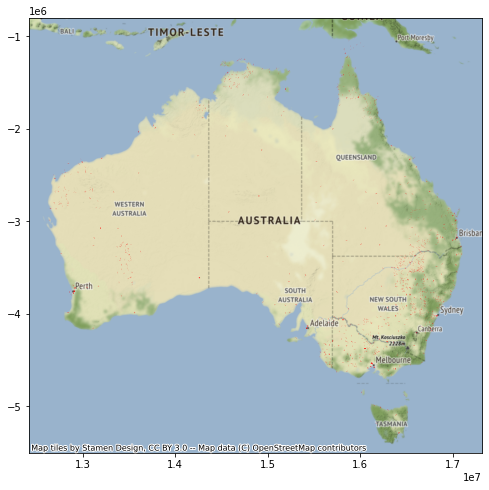

In [21]:
# Projection epsg:4283
import contextily as ctx
from pyproj import CRS
fig, ax = plt.subplots(figsize=(12,8))

data = centrelines.to_crs(epsg=3857)
data.plot(ax=ax, color="red")

ctx.add_basemap(ax)

